# VGG16으로 커스텀 데이터(이미지) 분류

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from IPython.display import display # 이미지 출력 함수
import numpy as np

Using TensorFlow backend.


## 커스텀 데이터로 학습



### 데이터 로더 준비

- Keras에서 제공하는 ImageDataGenerator를 사용한다.

- 적은 수의 데이터를 커버하기 위하여 데이터 증강을 한다.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'dental_image/train'
validation_dir = 'dental_image/test'
batch_size = 16  # 메모리가 충분하면 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
        rotation_range=180, # 회전 쵀대 20도
        width_shift_range=0.2, # 좌우 이동
        height_shift_range=0.2, # 상하 이동
        horizontal_flip=True, # 좌우 반전
        vertical_flip=True, # 상하 반전
)
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator()
 
# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

class_num=len(train_generator.class_indices)
custom_labels = list(validation_generator.class_indices.keys())

Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### 모델 새로 정의
이미 학습된 VGG16의 conv 레이어는 그대로 두고
Fully Connected 레이어 부분만 새로 정의한다.

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers
import keras.backend as K

K.clear_session() # 새로운 세션으로 시작

from keras.applications import VGG16

# 모델 불러오기
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
conv_layers.summary()

# Convolution Layer를 학습되지 않도록 고정 
for layer in conv_layers.layers:
    layer.trainable = False

# 새로운 모델 생성하기
model = models.Sequential()

# VGG16모델의 Convolution Layer를 추가
model.add(conv_layers)
 
# 모델의 Fully Connected 부분을 재구성
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_num, activation='softmax'))

# 모델
model.summary()

vgg16_model_path = 'model/new_trained_from_vgg16.h5'
model.save(vgg16_model_path)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 모델 학습

In [4]:
from keras.models import load_model

# 모델 로딩
model = load_model(vgg16_model_path)

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# 모델 학습
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# 모델 저장
model.save(vgg16_model_path)

C:\Users\ckkim\.conda\envs\tf2\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/100
10/9 [================================] - 17s 2s/step - loss: 22.5923 - acc: 0.4400 - val_loss: 0.5592 - val_acc: 0.5667
Epoch 2/100
10/9 [================================] - 11s 1s/step - loss: 9.7642 - acc: 0.5867 - val_loss: 1.4962 - val_acc: 0.5667
Epoch 3/100
10/9 [================================] - 9s 867ms/step - loss: 11.8157 - acc: 0.4933 - val_loss: 1.3368 - val_acc: 0.6167
Epoch 4/100
10/9 [================================] - 9s 858ms/step - loss: 8.8166 - acc: 0.6133 - val_loss: 0.7619 - val_acc: 0.6667
Epoch 5/100
10/9 [================================] - 9s 880ms/step - loss: 9.5493 - acc: 0.5867 - val_loss: 8.4819 - val_acc: 0.5500
Epoch 6/100
10/9 [================================] - 9s 858ms/step - loss: 7.1512 - acc: 0.6333 - val_loss: 0.3993 - val_acc: 0.6167
Epoch 7/100
10/9 [================================] - 9s 906ms/step - loss: 6.6454 - acc: 0.5800 - val_loss: 3.4246 - val_acc: 0.5167
Epoch 8/100
10/9 [================================] - 9s 907ms/s

Epoch 62/100
10/9 [================================] - 10s 966ms/step - loss: 0.7159 - acc: 0.8533 - val_loss: 0.2967 - val_acc: 0.6833
Epoch 63/100
10/9 [================================] - 10s 960ms/step - loss: 0.8167 - acc: 0.8600 - val_loss: 1.0121 - val_acc: 0.7167
Epoch 64/100
10/9 [================================] - 10s 966ms/step - loss: 1.0266 - acc: 0.8667 - val_loss: 0.6756 - val_acc: 0.7833
Epoch 65/100
10/9 [================================] - 10s 964ms/step - loss: 0.8750 - acc: 0.8600 - val_loss: 0.0187 - val_acc: 0.6500
Epoch 66/100
10/9 [================================] - 10s 964ms/step - loss: 1.2532 - acc: 0.8267 - val_loss: 0.3175 - val_acc: 0.7333
Epoch 67/100
10/9 [================================] - 11s 1s/step - loss: 1.6486 - acc: 0.8000 - val_loss: 0.4455 - val_acc: 0.6833
Epoch 68/100
10/9 [================================] - 9s 926ms/step - loss: 1.5358 - acc: 0.7733 - val_loss: 1.5246 - val_acc: 0.6500
Epoch 69/100
10/9 [================================]

## 학습 중의 로스와 정확도 보기
 accuracy와 loss의 그래프를 확인

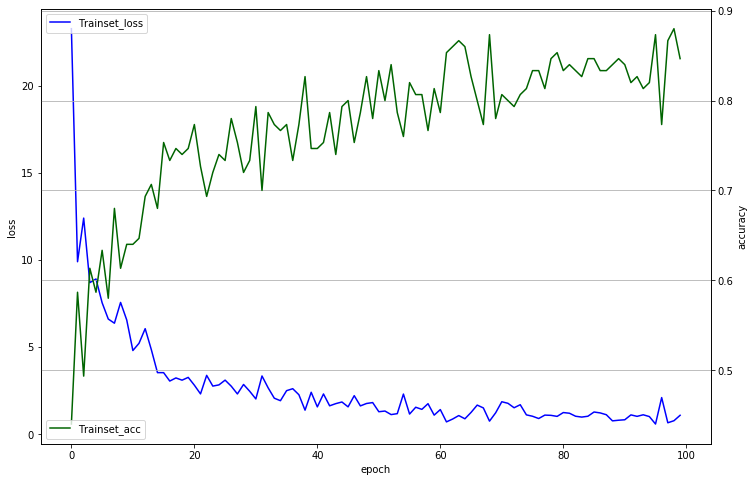

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(epochs, loss, c="blue", label='Trainset_loss')
ax0.set_ylabel('loss')
ax1.plot(epochs, acc, c="darkgreen", label='Trainset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper left')
ax1.legend(loc='lower left')
plt.grid()
plt.show()

## 새로 학습된 모델로 분류 실행

학습된 모델 파일을 읽어서 분류를 실행한다.


In [10]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import vgg16
from IPython.display import display
import numpy as np

def predict_custom_vgg16(model, filename) :
    image = load_img(filename)
    display(image)

    image = load_img(filename, target_size=(224, 224))

    image = img_to_array(image)
    image = image.reshape((1, 224, 224, 3))
    image = vgg16.preprocess_input(image)

    yhat = model.predict(image)

    # 최대 출력 인덱스를 구한다.
    idx=np.argmax(yhat[0])

    # 커스텀 레이블을 출력한다.
    print('%s (%.2f%%)' % (custom_labels[idx], yhat[0][idx]*100))


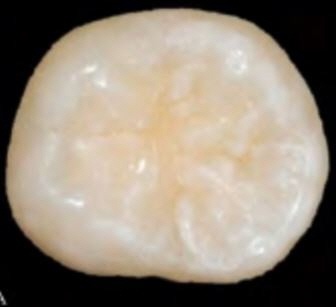

decayed (99.98%)


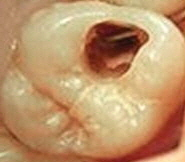

decayed (100.00%)


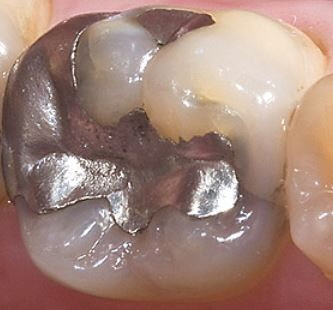

cured (99.99%)


In [11]:
from keras.models import load_model
model = load_model(vgg16_model_path)
  
files = [
    'dental_image/test/healthy/1.jpg',
    'dental_image/test/decayed/101.jpg',
    'dental_image/test/cured/301.jpg'
        ]

for file in files :
    predict_custom_vgg16(model, file)     
  